# Ejercicio 4 : Predicción

## Importar librerías necesarias

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import folium
from folium.plugins import HeatMap
from geopy.distance import geodesic
from datetime import datetime

## Cargar el dataset

In [16]:
data = pd.read_csv('/content/taxi_fare.csv')

## **Tarea 4a**: Realiza una descripción del dataset

### Eliminación de la característica "key"

Eliminamos "key" ya que no nos sirve para la predicción

In [17]:
data=data.drop(columns=['key'])

### Visualización en mapa de los valores de las coordenadas

Visualizamos los valores de las coordenadas para poder detectar posibles outliers

In [18]:
pickup_points = data[['pickup_latitude', 'pickup_longitude']].dropna()
dropoff_points = data[['dropoff_latitude', 'dropoff_longitude']].dropna()

nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

HeatMap(data=pickup_points).add_to(nyc_map)

nyc_map.save('nyc_heatmap.html')

from google.colab import files
files.download('nyc_heatmap.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Tarea 4b**: Realiza las tareas de pre-procesamiento

### Filtrar coordenadas

Al detectar coordenadas fuera de Nueva York o en el mar, establecemos el centro de Nueva York y un radio de 50km para filtrar coordenadas y así eliminar posibles outliers

In [19]:
nyc_center = (40.7128, -74.0060)
radius_km = 50

data = data[(data['pickup_latitude'] >= -90) & (data['pickup_latitude'] <= 90)]
data = data[(data['dropoff_latitude'] >= -90) & (data['dropoff_latitude'] <= 90)]
data = data[(data['pickup_longitude'] >= -180) & (data['pickup_longitude'] <= 180)]
data = data[(data['dropoff_longitude'] >= -180) & (data['dropoff_longitude'] <= 180)]

def within_radius(lat, lon, center, radius):
    return geodesic((lat, lon), center).km <= radius

data = data[
    data.apply(lambda row: within_radius(row['pickup_latitude'], row['pickup_longitude'], nyc_center, radius_km) and
                           within_radius(row['dropoff_latitude'], row['dropoff_longitude'], nyc_center, radius_km), axis=1)
]

### Coversión de la feacha y hora en valores numéricos

In [20]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], errors='coerce')

data = data.dropna(subset=['pickup_datetime'])

data['hour'] = data['pickup_datetime'].dt.hour
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['month'] = data['pickup_datetime'].dt.month

data = data.drop(columns=['pickup_datetime'])

### Visualización con el dataset limpio

In [21]:
pickup_points = data[['pickup_latitude', 'pickup_longitude']].dropna().sample(1000)
dropoff_points = data[['dropoff_latitude', 'dropoff_longitude']].dropna().sample(1000)

nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

for idx, row in pickup_points.iterrows():
    folium.Marker(location=[row['pickup_latitude'], row['pickup_longitude']],
                  icon=folium.Icon(color='blue')).add_to(nyc_map)

for idx, row in dropoff_points.iterrows():
    folium.Marker(location=[row['dropoff_latitude'], row['dropoff_longitude']],
                  icon=folium.Icon(color='red')).add_to(nyc_map)

nyc_map.save('nyc_map.html')

from google.colab import files
files.download('nyc_map.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Distribución del precio de tarifa

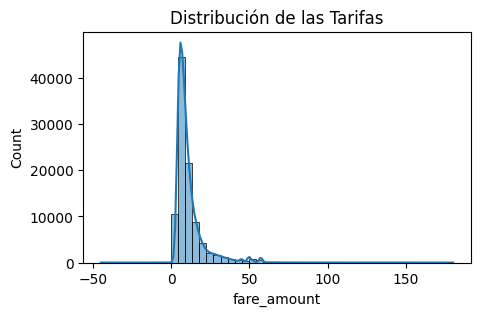

In [22]:

plt.figure(figsize=(5,3))
sns.histplot(data['fare_amount'], bins=50, kde=True)
plt.title('Distribución de las Tarifas')
plt.show()

### Correlación entre variables

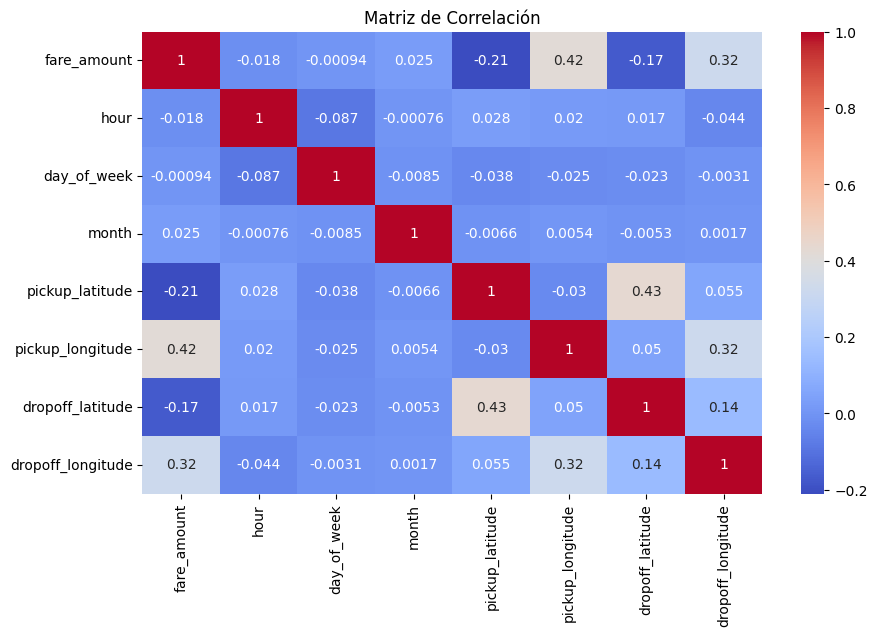

In [23]:

numeric_data = data[['fare_amount', 'hour', 'day_of_week', 'month',
                     'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]
plt.figure(figsize=(10,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

### Eliminar filas con valores nulos

In [24]:
data = data.dropna()

## **Tarea 4c**: Entrega y evalúa al menos 3 algoritmos para predicción

Aqui se hará lo siguiente:

1. Definir los límites máximos de fare_amount para la comparación.
2. Creación de un diccionario para almacenar los resultados.
3. Iterar sobre cada límite de fare_amount.
  1. Filtrar el dataset con el límite actual.
  2. Codificación de variables categóricas y normalización si es necesario.
  3. Separar características y objetivo.
  4. Convertir variables categóricas a dummy/indicadores.
  5. División en entrenamiento y prueba.
  6. Evaluación de modelos.
  7. Almacenar los resultados de cada modelo.
4. Convertir los resultados a un DataFrame.
5. Graficar los resultados


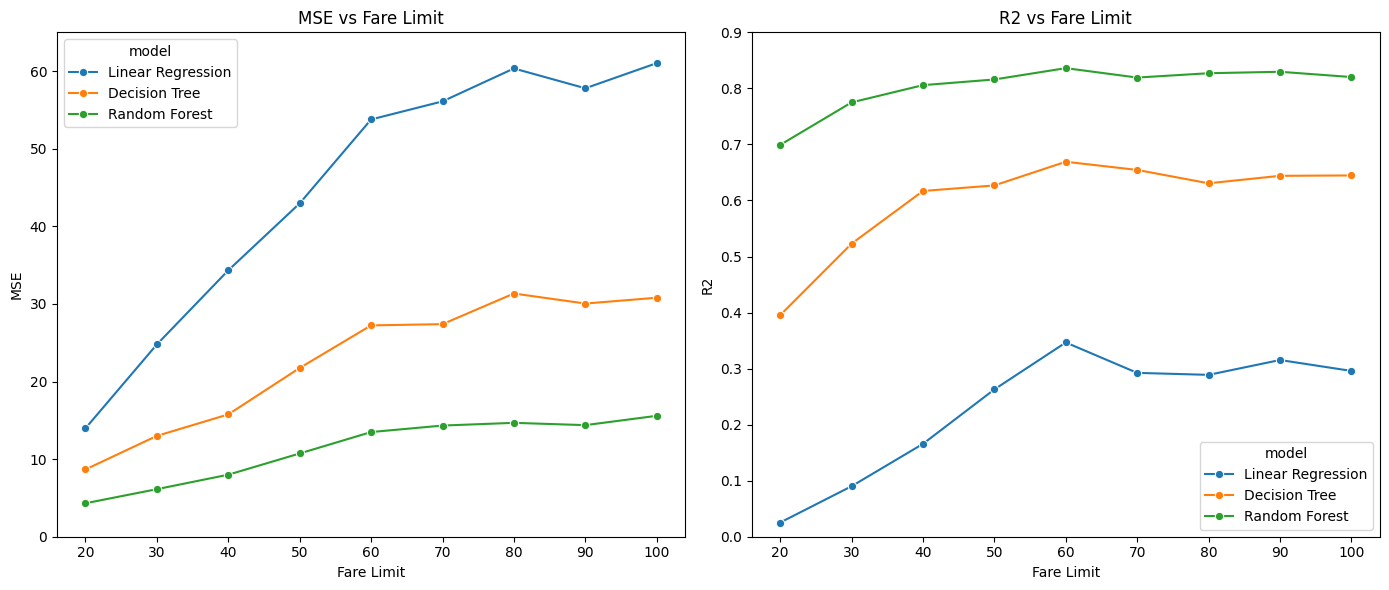

In [25]:
fare_limits = list(range(100, 10, -10))

results = {'fare_limit': [], 'model': [], 'MSE': [], 'R2': []}


for limit in fare_limits:

    filtered_data = data[(data['fare_amount'] > 0) & (data['fare_amount'] < limit)]


    data['passenger_count'] = data['passenger_count'].astype('category')


    X = filtered_data.drop(['fare_amount'], axis=1)
    y = filtered_data['fare_amount']


    X = pd.get_dummies(X, drop_first=True)


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    models = {
        "Linear Regression": LinearRegression(),
        "Decision Tree": DecisionTreeRegressor(),
        "Random Forest": RandomForestRegressor()
    }


    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)


        results['fare_limit'].append(limit)
        results['model'].append(name)
        results['MSE'].append(mse)
        results['R2'].append(r2)


results_df = pd.DataFrame(results)


plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
sns.lineplot(data=results_df, x='fare_limit', y='MSE', hue='model', marker='o')
plt.title('MSE vs Fare Limit')
plt.xlabel('Fare Limit')
plt.ylabel('MSE')
plt.ylim(bottom=0, top=65)


plt.subplot(1, 2, 2)
sns.lineplot(data=results_df, x='fare_limit', y='R2', hue='model', marker='o')
plt.title('R2 vs Fare Limit')
plt.xlabel('Fare Limit')
plt.ylabel('R2')
plt.ylim(bottom=0, top=0.9)

plt.tight_layout()
plt.show()
